In [813]:
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")

#data
data = pd.read_csv('./global.csv')
print(data.shape)


#Goal
# imputation of data
# Find features that best represent Value_co2_emissions_kt_by_country (feature selection)
# Create a model that predicts Value_co2_emissions_kt_by_country for each Regressor (Lasso, Ridge, RandomForest)
# Determine threshold and one hot encode Value_co2_emissions_kt_by_country
# Classify new binary labels

(3649, 21)


In [814]:
#Data Preprocessing 

columns = data.select_dtypes(exclude=['object'])

dropped_columns = ["Year","Value_co2_emissions_kt_by_country", "Longitude", "Latitude"]

imputed_data = data.drop(["Density(P/Km2)", "Longitude", "Latitude"], axis=1)

#Assign mean of the column values in respect to the Country
for col in columns:
    if col not in dropped_columns:        
        mean_by_country = imputed_data.groupby('Entity')[col].mean()
        for entity, value in mean_by_country.items():
            if math.isnan(value):
                mean_by_country[entity] = imputed_data[col].median()
        imputed_data[col] = imputed_data[col].fillna(imputed_data['Entity'].map(mean_by_country))

#Drop remaining records with NaN in Year and Value_co2_emissions_kt_by_country
imputed_data = imputed_data.dropna()

print(f"{imputed_data.isnull().sum()}")
print(f"data shape after imputation: {imputed_data.shape}")


Entity                                                              0
Year                                                                0
Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Renewable-electricity-generating-capacity-per-capita                0
Financial flows to developing countries (US $)                      0
Renewable energy share in the total final energy consumption (%)    0
Electricity from fossil fuels (TWh)                                 0
Electricity from nuclear (TWh)                                      0
Electricity from renewables (TWh)                                   0
Low-carbon electricity (% electricity)                              0
Primary energy consumption per capita (kWh/person)                  0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0
Value_co2_emissions_kt_by_country                                   0
Renewables (% equiva

In [815]:
# Feature selection

from sklearn.feature_selection import SelectKBest, r_regression

def feature_selection_k_means(k, data):
    columns = data.select_dtypes(exclude=['object'])
    columns = columns.drop(["Year", "Value_co2_emissions_kt_by_country"], axis=1)

    X = data.drop(['Entity', 'Year', 'Value_co2_emissions_kt_by_country'], axis=1)

    y = data['Value_co2_emissions_kt_by_country']

    skb = SelectKBest(r_regression, k=k)

    X_new = skb.fit_transform(X, y)

    feature_indices = skb.get_support(indices=True)

    return (X.columns[feature_indices], X_new)
    

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Access to electricity (% of population)'),
  Text(1, 0, 'Access to clean fuels for cooking'),
  Text(2, 0, 'Renewable-electricity-generating-capacity-per-capita'),
  Text(3, 0, 'Financial flows to developing countries (US $)'),
  Text(4, 0, 'Renewable energy share in the total final energy consumption (%)'),
  Text(5, 0, 'Electricity from fossil fuels (TWh)'),
  Text(6, 0, 'Electricity from nuclear (TWh)'),
  Text(7, 0, 'Electricity from renewables (TWh)'),
  Text(8, 0, 'Low-carbon electricity (% electricity)'),
  Text(9, 0, 'Primary energy consumption per capita (kWh/person)'),
  Text(10, 0, 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'),
  Text(11, 0, 'Renewables (% equivalent primary energy)'),
  Text(12, 0, 'gdp_growth'),
  Text(13, 0, 'gdp_per_capita'),
  Text(14, 0, 'Land Area(Km2)')])

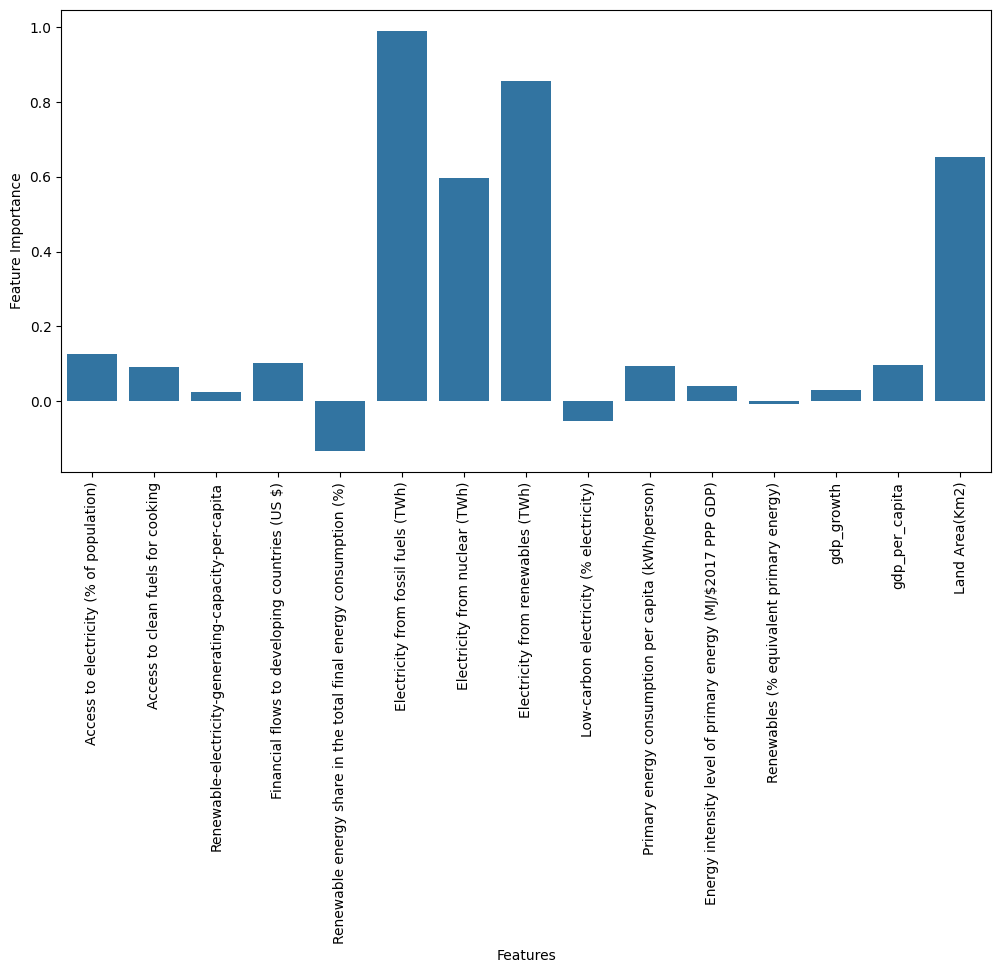

In [816]:
#identifying importance of features through SelectKBest
import seaborn as sns

skb = SelectKBest(r_regression, k=5)
X = imputed_data.drop(["Value_co2_emissions_kt_by_country", "Entity", "Year"], axis=1)
y = imputed_data["Value_co2_emissions_kt_by_country"]
skb.fit_transform(X, y)

feature_indices = skb.get_support(indices=True)

plt.figure(figsize=(12, 6))
plt.ylabel("Feature Importance")
plt.xlabel("Features")
ax =sns.barplot(x=X.columns, y=skb.scores_)
plt.xticks(rotation=90, fontsize=10)



In [817]:
# Find the best amount of features to use with respect to mean absolute error

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def best_reg(reg, name):

    amount_of_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    y = imputed_data['Value_co2_emissions_kt_by_country']
    
    errors = []
    corr_feature_names = []
    temp_data = imputed_data.copy(deep=True)

    for k in amount_of_features:

        feature_names, X_new = feature_selection_k_means(k, temp_data.copy(deep=True))

        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

        curr_mae = float('inf')

        if name in ["LassoCV", "RidgeCV"]:
            lcv = reg(cv=5)
            lcv.fit(X_train, y_train)
            y_pred = lcv.predict(X_test)
            curr_mae = min(curr_mae, mean_absolute_error(y_test, y_pred))
        else:
            lcv = reg()
            lcv.fit(X_train, y_train)
            y_pred = lcv.predict(X_test)
            curr_mae = min(curr_mae, mean_absolute_error(y_test, y_pred))


        errors.append(curr_mae)
        corr_feature_names.append(feature_names)

    best_mae = min(errors)
    print(f"Best Features for {name}")
    for feature in corr_feature_names[errors.index(best_mae)]:
        print(feature)

    print(f"mae: {best_mae}")
    return (best_mae, name)


In [818]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
lcv_mae, lcv = best_reg(LassoCV, "lassoCV")
rcv_mae, rcv = best_reg(RidgeCV, "RidgeCV")
rfr_mae, rfr = best_reg(RandomForestRegressor, "Random Forest Regressor")

# finds the best model in respect to mean absolute error and the best amount of features in respect to each regression
best_reg = min(lcv_mae, min(rcv_mae,rfr_mae))

Best Features for lassoCV
Electricity from fossil fuels (TWh)
Electricity from renewables (TWh)
mae: 27175.68895689358
Best Features for RidgeCV
Electricity from fossil fuels (TWh)
Electricity from renewables (TWh)
mae: 27431.501694769046
Best Features for Random Forest Regressor
Electricity from fossil fuels (TWh)
Electricity from renewables (TWh)
Land Area(Km2)
mae: 10857.344274386782


In [819]:
# import torch
# from torch.nn import Sequential
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader

# class AirModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lstm = nn.LSTM(5, 50, 1, batch_first=True)
#         self.linear = nn.Linear(50, 1)
#     def forward(self, x):
#         x, _ = self.lstm(x)
#         x = self.linear(x)
#         return x

# feature_names, X_new = feature_selection_k_means(5, imputed_data.copy())
# y = imputed_data['Value_co2_emissions_kt_by_country']
# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset,batch_size=8, shuffle=True, num_workers=0)

# model = AirModel()


In [820]:
# #keras
# import statsmodels.api as sm
# import numpy as np
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM

# p_values = range(0, 3)
# d_values = range(0, 3)
# q_values = range(0, 3)

# feature_names, X_new = feature_selection_k_means(2, imputed_data.copy(deep=True))
# y = imputed_data["Value_co2_emissions_kt_by_country"]

# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

# history = X_train
# predictions = []
# for i in range(len(X_test)):
#     model = sm.tsa.arima.ARIMA(history, order = (0, 0, 0))
#     model.initialize_approximate_diffuse()
#     model_fit = model.fit()
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat)
#     history.loc[len(history.index)] = X_test[i]
# history

# model = Sequential()
# model.add(Dense(50,input_dim = X_train.shape[1], activation='relu'))
# model.add(Dropout(0.5))
# model.add(LSTM(y,dropout_U = 0.2, dropout_W = 0.2))


In [821]:
# model = Sequential()
# model.add(Dense(50,input_dim = X_train.shape[1], activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(50, input_dim = 50, acitivation='linear'))

# loss_func = nn.L1Loss() #loss function
# opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# epochs = 1

# for epoch in range(epochs):   
#     run_loss = 0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         opt.zero_grad()
#         outputs = model(inputs)
#         loss = loss_func(outputs, labels)

#         loss.backward()
#         opt.step()
# print('Finished Training')

In [822]:

# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.long)
# test_dataset = TensorDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset)

# with torch.no_grad():
#     for data in test_loader:
#         (images, labels) = data
#         outputs = model(images)
#         print(outputs)

In [823]:
#concluded that RandomForestRegressor was the best model.

#hypertuning RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 2, 5, 10],
}

feature_names, X_new = feature_selection_k_means(6, imputed_data.copy(deep=True))

y = imputed_data['Value_co2_emissions_kt_by_country']

y.shape

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

rfr = RandomForestRegressor()

random_search = RandomizedSearchCV(
    rfr,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)





Best Hyperparameters: {'n_estimators': 100, 'max_depth': 10}


In [824]:
#accuracy of RandomForestRegressor

from sklearn.metrics import r2_score

rfr = RandomForestRegressor(n_estimators=200, max_depth=10)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print(f"accuracy for RandomForestRegressor : {r2_score(y_test, y_pred)}")


accuracy for RandomForestRegressor : 0.9932456117686691


In [825]:
#hypertuning LassoCV

param_grid = {
    'tol': [0.1, 0.001, 0.0001, 0.00001],

}

feature_names, X_new = feature_selection_k_means(2, imputed_data.copy())

y = imputed_data['Value_co2_emissions_kt_by_country']

y.shape

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

lcv = LassoCV()

random_search = RandomizedSearchCV(
    lcv,
    param_distributions=param_grid,
    n_iter=4,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'tol': 1e-05}


In [826]:
#accuracy of LassoCV

from sklearn.metrics import r2_score

rfr = LassoCV(cv=5,tol=1e-05)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print(f"accuracy for LassoCV : {r2_score(y_test, y_pred)}")

accuracy for LassoCV : 0.9806625551343409


In [827]:
#find most accurate country with respect to LassoCV

countries = np.array(list(set(imputed_data["Entity"])))


country_and_r2score_and_df = []

y_pred_and_y_test = []

for country in countries:
    feature_names, X_new = feature_selection_k_means(2, imputed_data.copy())

    df = imputed_data[imputed_data["Entity"] == country]

    X = df[feature_names]
    X["Year"] = df["Year"]
    y = df["Value_co2_emissions_kt_by_country"]

    if len(X) > 10:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        rfr = LassoCV(cv=5, tol=1e-05)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_test)

        country_and_r2score_and_df.append((country, r2_score(y_test, y_pred), X_test))
        y_pred_and_y_test.append((y_pred, y_test))
    

maxr2 = 0
most_accurate_country = None
corr_df = None
for country, r2score, curr_df in country_and_r2score_and_df:
    if maxr2 < r2score:
        maxr2 = r2score
        most_accurate_country = country
        corr_df = curr_df
print(maxr2)
print(most_accurate_country)


        




0.9939774988335277
China


most accurate prediction: China
r2score: 0.9939774988335277


<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.10/site-packages/matplotlib/pyplot.py'>

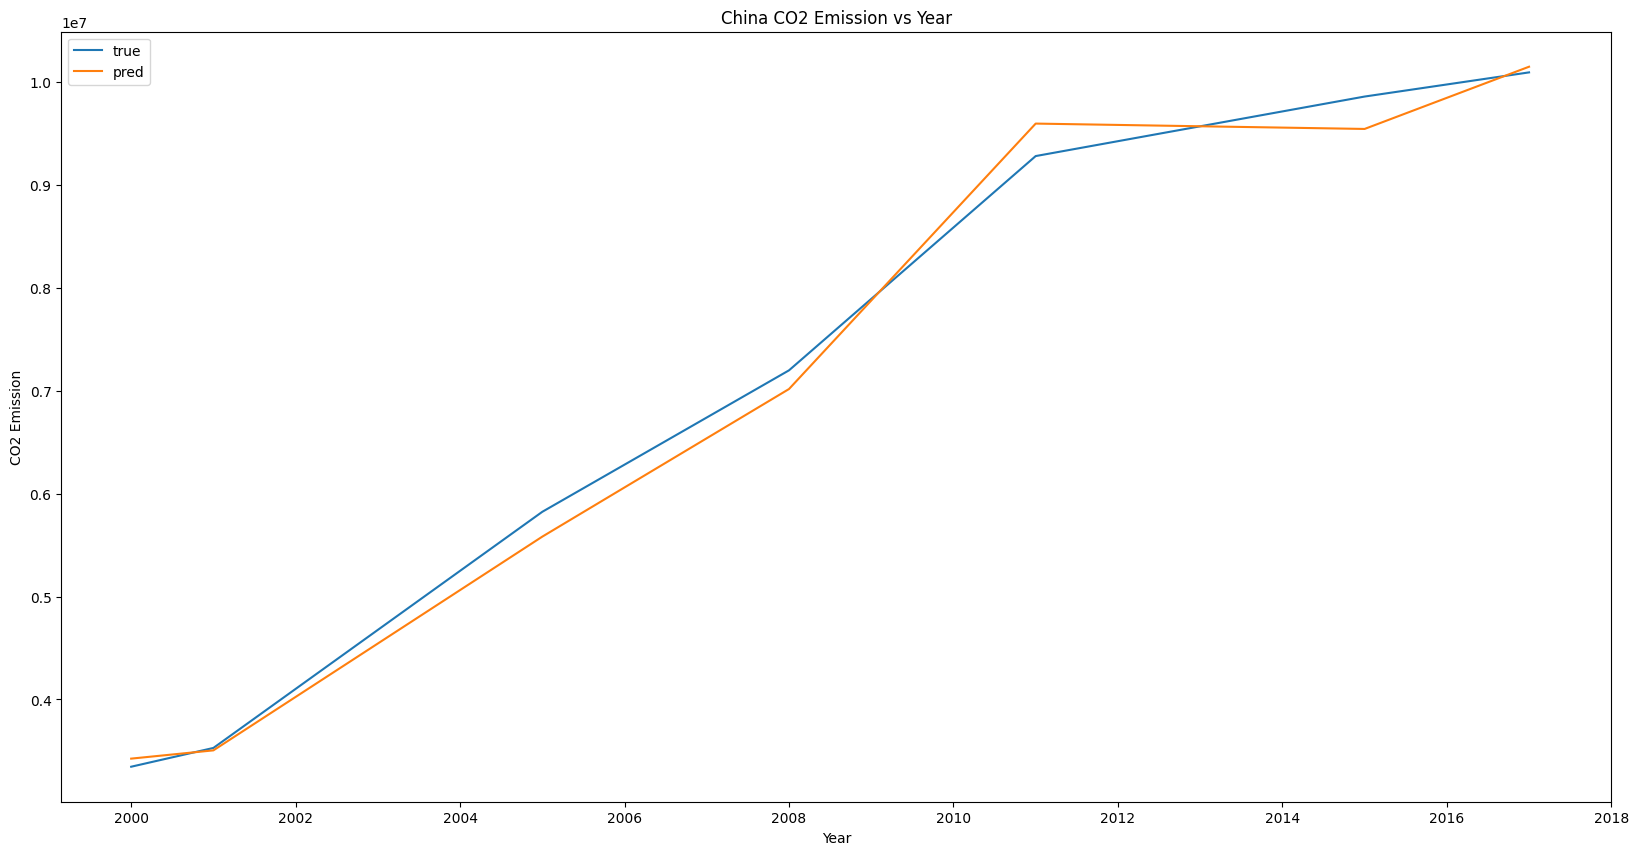

In [828]:
#Visualization of LassoCV
print(f"most accurate prediction: {most_accurate_country}")
print(f"r2score: {maxr2}")
index = country_and_r2score_and_df.index((most_accurate_country, maxr2, corr_df))

y_pred, y_test = y_pred_and_y_test[index]

corr_df['y_pred'] = y_pred
corr_df['y_test'] = y_test

corr_df_sorted = corr_df.sort_values(by='Year')

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_test"], label="true")
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_pred"], label="pred")
plt.xticks(range(2000, 2020, 2))
plt.title("China CO2 Emission vs Year")
plt.xlabel("Year")
plt.ylabel("CO2 Emission")
plt.legend()
plt


In [829]:
#Find most accurate country with respect to RidgeCV
countries = np.array(list(set(imputed_data["Entity"])))


country_and_r2score_and_df = []

y_pred_and_y_test = []

for country in countries:
    feature_names, X_new = feature_selection_k_means(2, imputed_data.copy())

    df = imputed_data[imputed_data["Entity"] == country]

    X = df[feature_names]
    X["Year"] = df["Year"]
    y = df["Value_co2_emissions_kt_by_country"]

    if len(X) > 10:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        rfr = RidgeCV(cv=5)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_test)

        country_and_r2score_and_df.append((country, r2_score(y_test, y_pred), X_test))
        y_pred_and_y_test.append((y_pred, y_test))
    

maxr2 = 0
most_accurate_country = None
corr_df = None
for country, r2score, curr_df in country_and_r2score_and_df:
    if maxr2 < r2score:
        maxr2 = r2score
        most_accurate_country = country
        corr_df = curr_df
print(maxr2)
print(most_accurate_country)

0.9941928268299823
Bahrain


most accurate prediction: Bahrain
r2score: 0.9941928268299823


<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.10/site-packages/matplotlib/pyplot.py'>

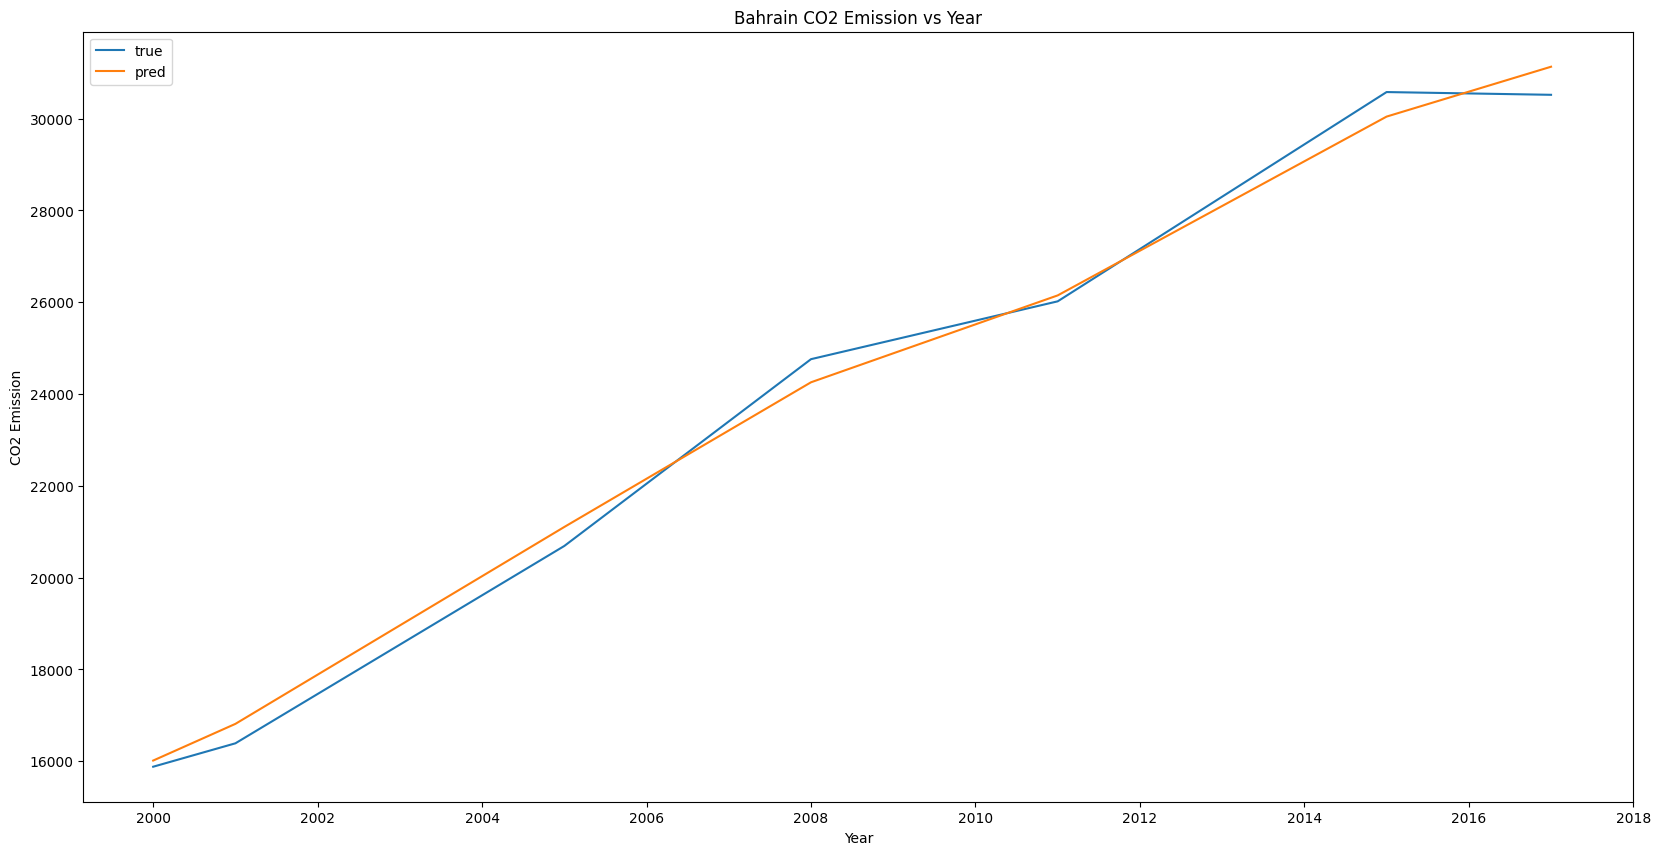

In [830]:
#Visualization of RidgeCV
print(f"most accurate prediction: {most_accurate_country}")
print(f"r2score: {maxr2}")
index = country_and_r2score_and_df.index((most_accurate_country, maxr2, corr_df))
y_pred, y_test = y_pred_and_y_test[index]

corr_df['y_pred'] = y_pred
corr_df['y_test'] = y_test

corr_df_sorted = corr_df.sort_values(by='Year')

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_test"], label="true")
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_pred"], label="pred")
plt.title("Bahrain CO2 Emission vs Year")
plt.xlabel("Year")
plt.ylabel("CO2 Emission")
plt.xticks(range(2000, 2020, 2))
plt.legend()
plt

In [831]:
#find most accurate country with respect to RandomForestRegressor

countries = np.array(list(set(imputed_data["Entity"])))


country_and_r2score_and_df = []

y_pred_and_y_test = []

for country in countries:
    feature_names, X_new = feature_selection_k_means(9, imputed_data.copy())

    df = imputed_data[imputed_data["Entity"] == country]

    X = df[feature_names]
    X["Year"] = df["Year"]
    y = df["Value_co2_emissions_kt_by_country"]

    if len(X) > 10:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        rfr = RandomForestRegressor()
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_test)

        country_and_r2score_and_df.append((country, r2_score(y_test, y_pred), X_test))
        y_pred_and_y_test.append((y_pred, y_test))
    

maxr2 = 0
most_accurate_country = None
corr_df = None
for country, r2score, curr_df in country_and_r2score_and_df:
    if maxr2 < r2score:
        maxr2 = r2score
        most_accurate_country = country
        corr_df = curr_df
print(maxr2)
print(most_accurate_country)

0.9948370688771732
Peru


most accurate prediction: Peru
r2score: 0.9948370688771732


<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.10/site-packages/matplotlib/pyplot.py'>

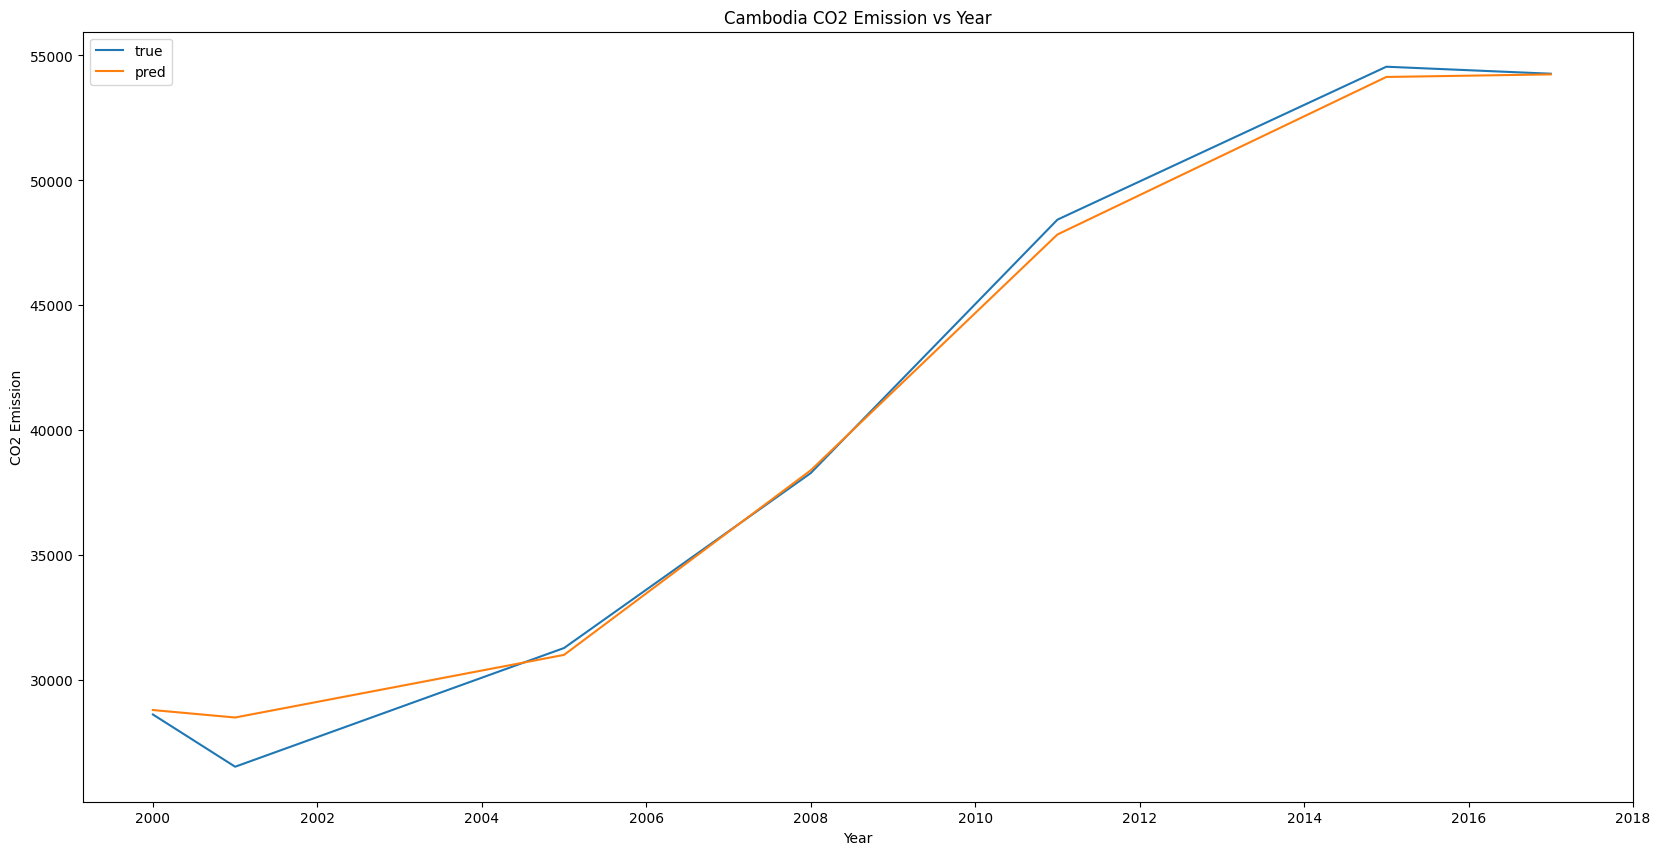

In [832]:
#Visualization of RandomForestRegressor
print(f"most accurate prediction: {most_accurate_country}")
print(f"r2score: {maxr2}")
index = country_and_r2score_and_df.index((most_accurate_country, maxr2, corr_df))
y_pred, y_test = y_pred_and_y_test[index]

corr_df['y_pred'] = y_pred
corr_df['y_test'] = y_test

corr_df_sorted = corr_df.sort_values(by='Year')

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_test"], label="true")
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_pred"], label="pred")
plt.title("Cambodia CO2 Emission vs Year")
plt.xlabel("Year")
plt.ylabel("CO2 Emission")
plt.xticks(range(2000, 2020, 2))
plt.legend()
plt

lowerbound: -0.0076155344840328236
upperbound: 0.013263201004610238


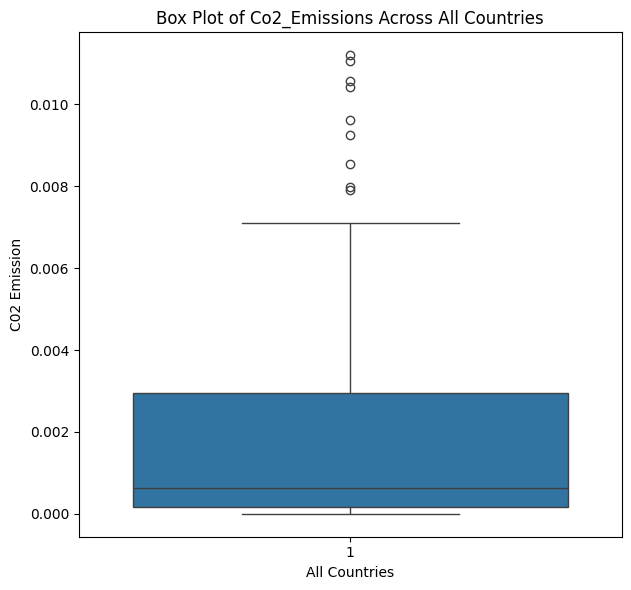

In [833]:
#Creating IQR BoxPlot for Visual Representation of CO2 emissions per country

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#Normalization
scalar = MinMaxScaler()

new_imputed_data = imputed_data.drop('Year',axis=1)

num_cols = new_imputed_data.select_dtypes(include=['number'])
num_cols_labels = list(num_cols.columns)
agg_data = new_imputed_data
agg_data[num_cols_labels] = scalar.fit_transform(imputed_data.drop(["Entity", "Year"], axis=1))

# new_agg_data = agg_data.groupby("Entity").mean().reset_index()

# aggreggating the data Frame with respect to the mean of each country
agg_data = agg_data.groupby("Entity")["Value_co2_emissions_kt_by_country"].mean().reset_index()

#Obtain the 25th and 75th Quantile
Q1 = agg_data["Value_co2_emissions_kt_by_country"].quantile(0.25)
Q3 = agg_data["Value_co2_emissions_kt_by_country"].quantile(0.75)

#Calculate IQR
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

print(f"lowerbound: {lower_bound}")
print(f"upperbound: {upper_bound}")

lower_bound_cond = (agg_data["Value_co2_emissions_kt_by_country"] >= lower_bound)
upper_bound_cond = (agg_data["Value_co2_emissions_kt_by_country"] <= upper_bound)

filtered_data = agg_data["Value_co2_emissions_kt_by_country"][lower_bound_cond & upper_bound_cond]

plt.figure(figsize=(12, 6))
y = filtered_data
x = 1
plt.subplot(1, 2, 1)
sns.boxplot(x=x, y=y)
plt.title('Box Plot of Co2_Emissions Across All Countries')
plt.xlabel("All Countries")
plt.ylabel("C02 Emission")
plt.tight_layout()
plt.show()

In [834]:
from sklearn.neighbors import KNeighborsClassifier

scalar = MinMaxScaler()

new_imputed_data = imputed_data.drop('Year',axis=1)

num_cols = new_imputed_data.select_dtypes(include=['number'])
num_cols_labels = list(num_cols.columns)

agg_data = new_imputed_data
agg_data[num_cols_labels] = scalar.fit_transform(imputed_data.drop(["Entity", "Year"], axis=1))

threshold1 = np.percentile(agg_data["Value_co2_emissions_kt_by_country"], 50)

cond = [
    agg_data["Value_co2_emissions_kt_by_country"] <= threshold1,
    agg_data["Value_co2_emissions_kt_by_country"] > threshold1,
]

labels = [0, 1]
#one hot encoding CO2 emissions based on threshold
agg_data['co2_category'] = np.select(cond, labels)


#Train on K Nearest Neighbor to check Classification with respect to aggregated data
X_new = agg_data.drop(["Value_co2_emissions_kt_by_country", "Entity", "co2_category"], axis=1)
y = agg_data["co2_category"]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

nns = [3, 5, 8, 10, 12, 14]
best_r2 = 0
best_nn = None
for nn in nns:
    knn = KNeighborsClassifier(n_neighbors=nn)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    if best_r2 < r2_score(y_test, y_pred):
        best_r2 = r2_score(y_test, y_pred)
        best_nn = nn

print(f"best r2 score: {best_r2} and corresponding nn: {nn}")

best r2 score: 0.8833034683513822 and corresponding nn: 14


In [835]:
#obtain countries that have both labels at one point in time
import numpy as np
# us_data = agg_data[(agg_data["Entity"]) == "Mexico"]
countries = set(agg_data["Entity"])
even_countries = []

for country in countries:
    agg_data[(agg_data["Entity"]) == country]["co2_category"]
    if (len(np.unique(agg_data[(agg_data["Entity"]) == country]["co2_category"])) > 1):
        even_countries.append(country)

even_countries

['Senegal',
 'Sudan',
 'Estonia',
 'Ghana',
 'Nepal',
 'Luxembourg',
 'Cambodia',
 'Myanmar',
 'Zimbabwe',
 'Ethiopia',
 'Jamaica',
 'Guatemala',
 'Panama',
 'Kenya',
 'Trinidad and Tobago',
 'Mongolia']

r2 score for K-Nearest Neighbors: 0.5586206896551724


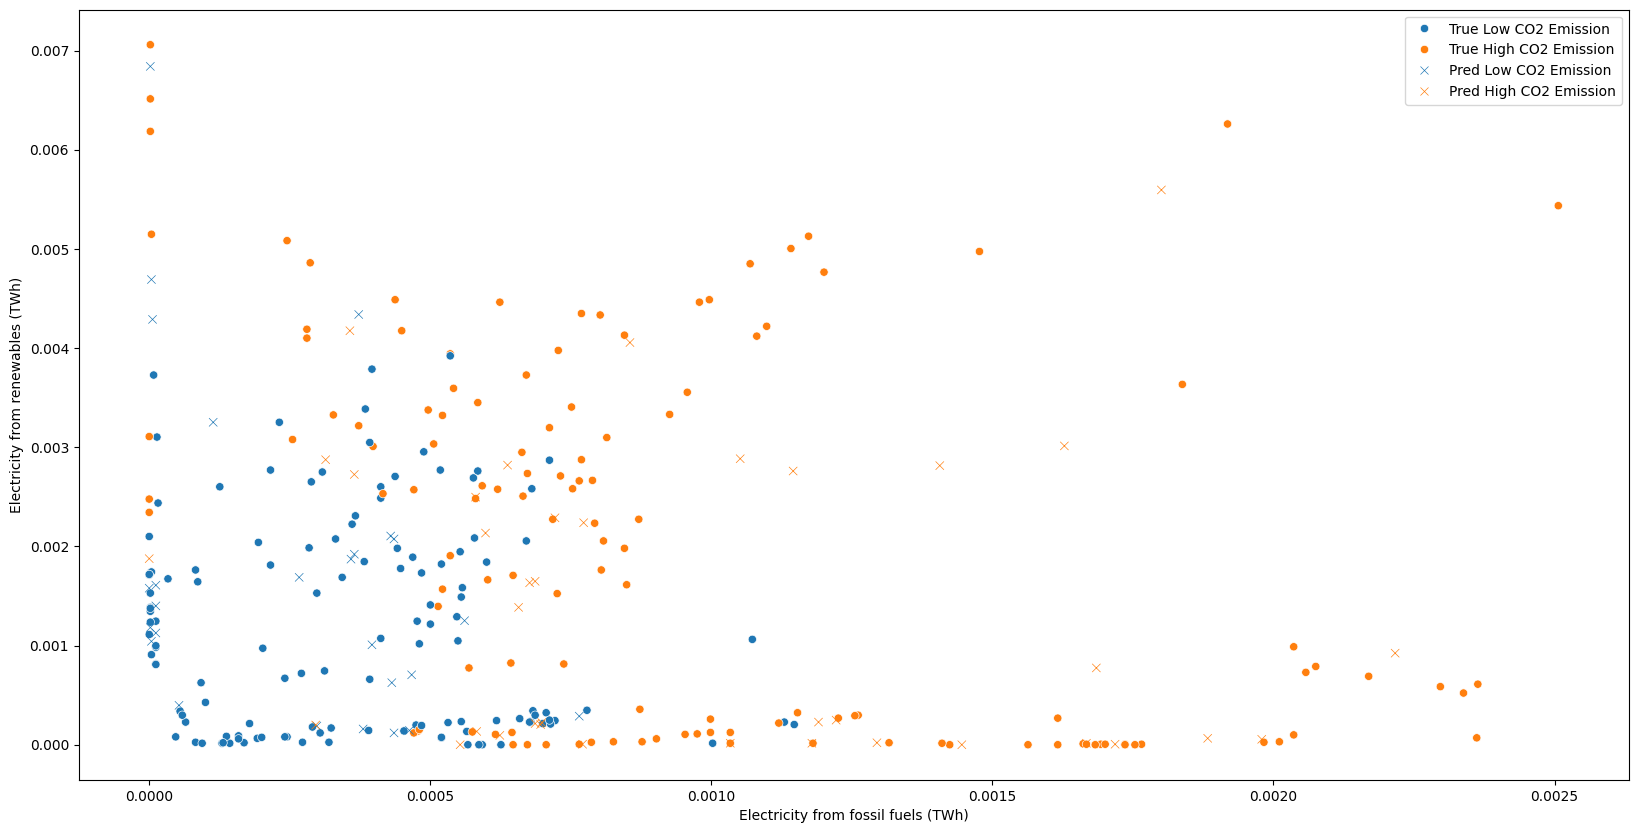

In [836]:

#Classification using K-Nearest Neighbors and corresponding scatterplot

selected_data = [agg_data[agg_data["Entity"] == country] for country in even_countries]

ghana_data = pd.concat(selected_data, axis=0)

# ghana_data = ghana_data[['Electricity from fossil fuels (TWh)', "Electricity from renewables (TWh)", "co2_category", "Entity"]]

X_new = ghana_data.drop(["co2_category", "Entity", "Value_co2_emissions_kt_by_country"], axis=1)
y = ghana_data["co2_category"]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

plt.figure(figsize=(20, 10))
scatter1 = sns.scatterplot(x=X_train["Electricity from fossil fuels (TWh)"], y=X_train["Electricity from renewables (TWh)"], hue=y_train, marker='o')


best_r2 = 0
best_nn = None
nns = [3, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24]
for nn in nns:
    knn = KNeighborsClassifier(n_neighbors=nn)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    if best_r2 < r2_score(y_test, y_pred):
        best_r2 = r2_score(y_test, y_pred)
        best_nn = nn

print(f"r2 score for K-Nearest Neighbors: {best_r2}")

scatter = sns.scatterplot(x=X_test["Electricity from fossil fuels (TWh)"], y=X_test["Electricity from renewables (TWh)"], hue=y_pred, marker='x')

scatter.legend_.texts[0].set_text("True Low CO2 Emission")
scatter.legend_.texts[1].set_text("True High CO2 Emission")
scatter.legend_.texts[2].set_text("Pred Low CO2 Emission")
scatter.legend_.texts[3].set_text("Pred High CO2 Emission")


In [854]:
#Classification with RandomForestClassifier with corresponding scatter plot
from sklearn.ensemble import RandomForestClassifier
selected_data = [agg_data[agg_data["Entity"] == country] for country in even_countries]

ghana_data = pd.concat(selected_data, axis=0)

# ghana_data = ghana_data[['Electricity from fossil fuels (TWh)', "Electricity from renewables (TWh)", "co2_category", "Entity"]]

X_new = ghana_data.drop(["co2_category", "Entity", "Value_co2_emissions_kt_by_country"], axis=1)
y = ghana_data["co2_category"]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [None, 2, 5, 10],
    'criterion': ["gini", "entropy", "log_loss"],
    'n_estimators': [50, 100, 150, 200],    
}

clf = RandomForestClassifier()

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=100,
    cv=5, 
    random_state=42,
    n_jobs=-1 
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"r2 score for Random Forest Classifier: {r2_score(y_test, y_pred)}")


r2 score for Random Forest Classifier: 0.8108374384236453


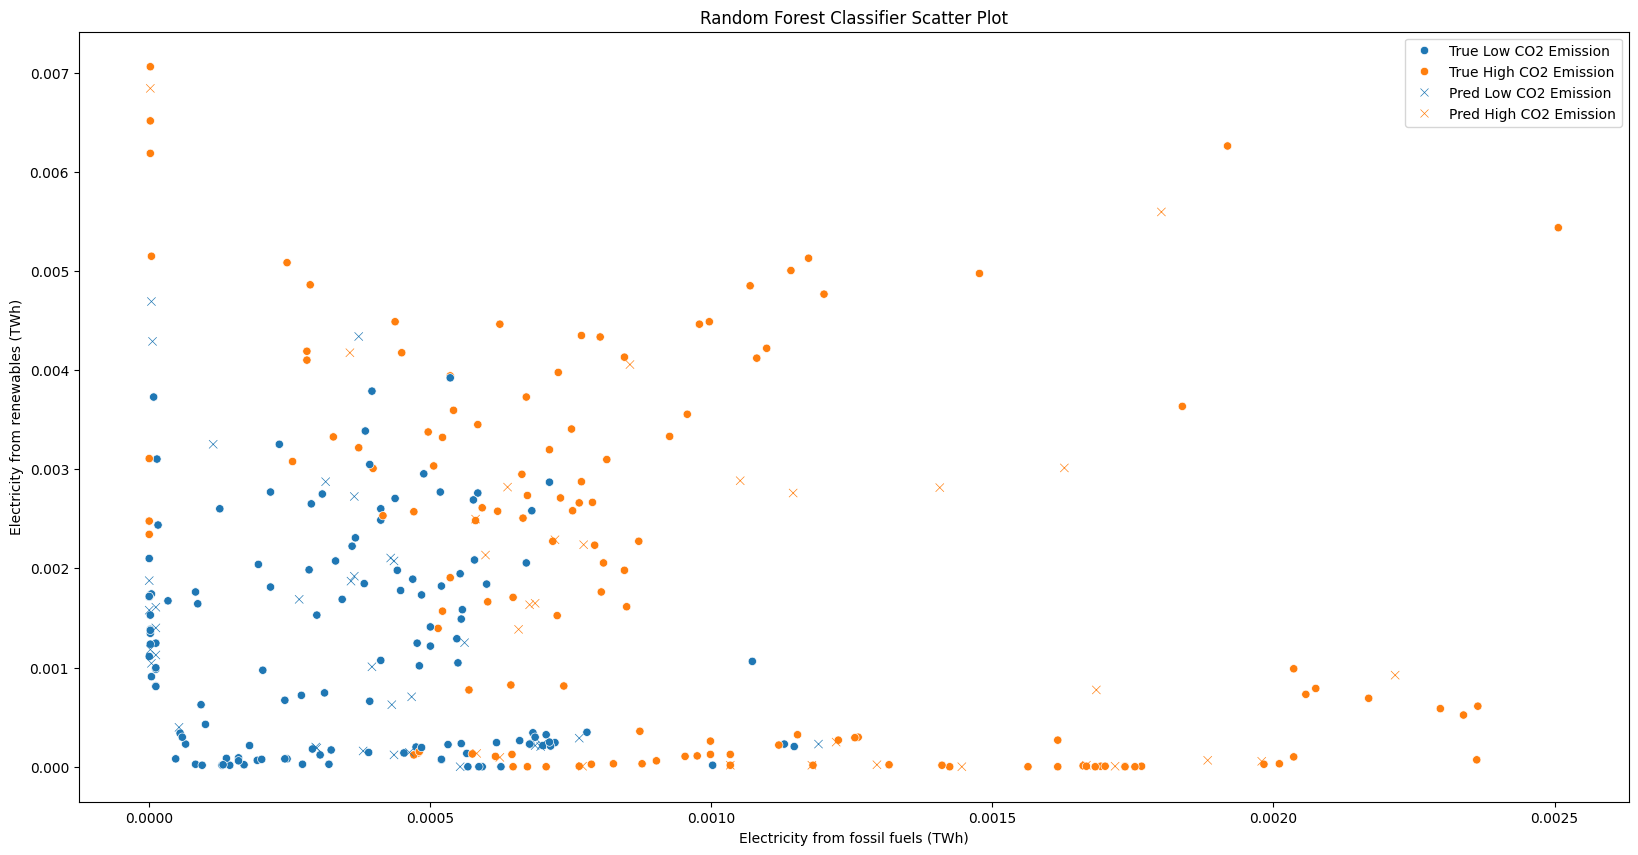

In [838]:
#Plot for Random Forest Classifier
plt.figure(figsize=(20, 10))

scatter1 = sns.scatterplot(x=X_train["Electricity from fossil fuels (TWh)"], y=X_train["Electricity from renewables (TWh)"], hue=y_train, marker='o')

scatter = sns.scatterplot(x=X_test["Electricity from fossil fuels (TWh)"], y=X_test["Electricity from renewables (TWh)"], hue=y_pred, marker='x')

plt.title("Random Forest Classifier Scatter Plot")
scatter.legend_.texts[0].set_text("True Low CO2 Emission")
scatter.legend_.texts[1].set_text("True High CO2 Emission")
scatter.legend_.texts[2].set_text("Pred Low CO2 Emission")
scatter.legend_.texts[3].set_text("Pred High CO2 Emission")

[0 1 1 0 0 0 1]
1.0


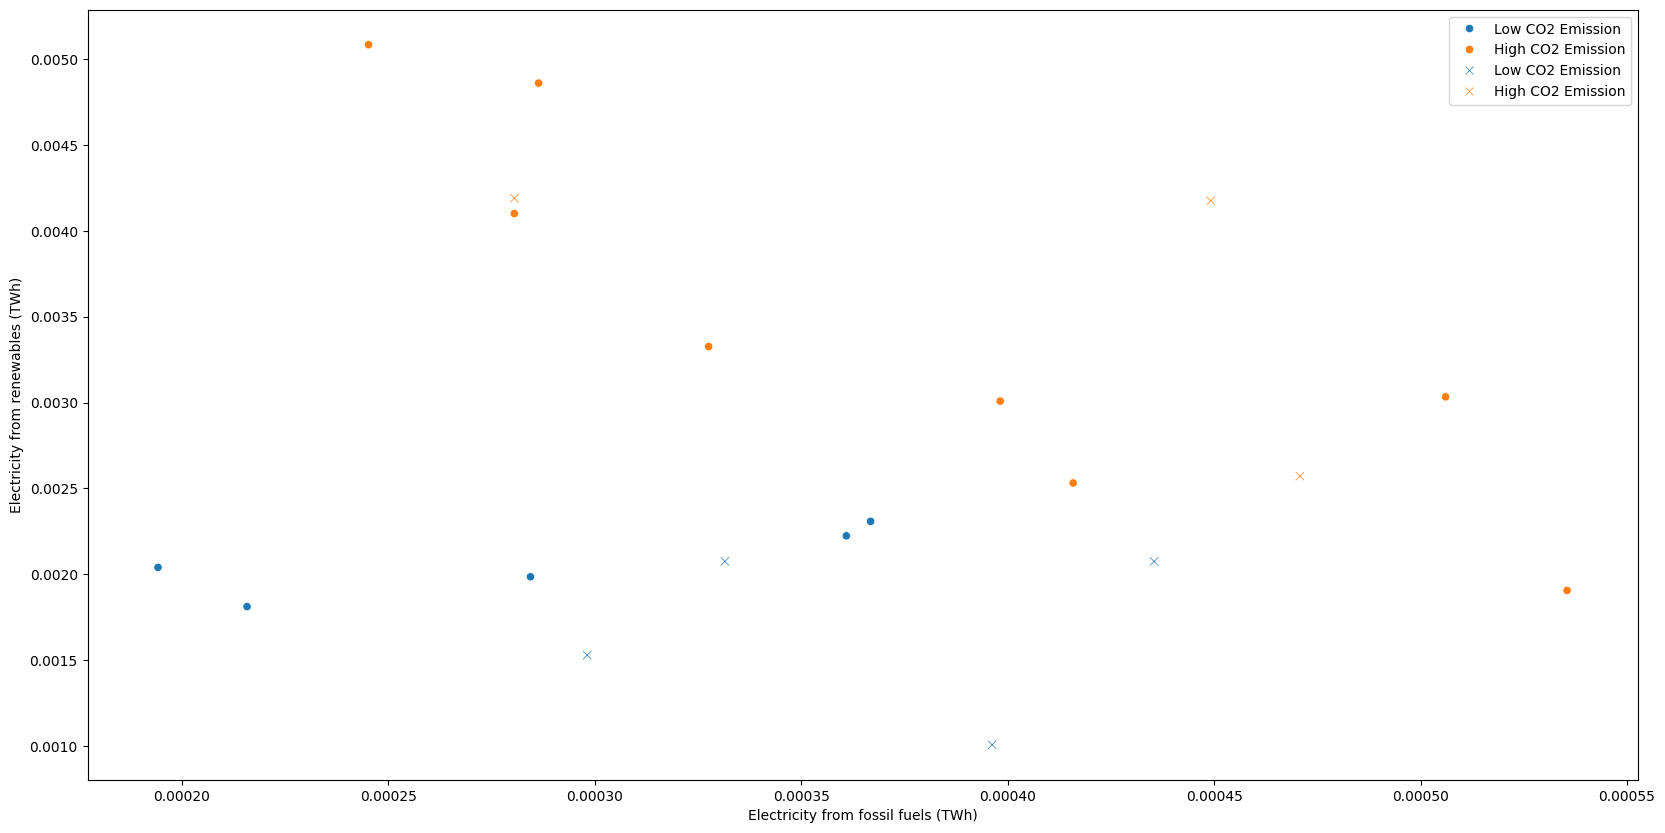

In [839]:
#DELETE

kenya_data = agg_data[(agg_data["Entity"]) == 'Kenya']

X_new = kenya_data.drop(["co2_category", "Entity"], axis=1)
y = kenya_data["co2_category"]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

plt.figure(figsize=(20, 10))
scatter1 = sns.scatterplot(x=X_train["Electricity from fossil fuels (TWh)"], y=X_train["Electricity from renewables (TWh)"], hue=y_train, marker='o')


knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(y_pred)

scatter = sns.scatterplot(x=X_test["Electricity from fossil fuels (TWh)"], y=X_test["Electricity from renewables (TWh)"], hue=y_pred, marker='x')

scatter.legend_.texts[0].set_text("Low CO2 Emission")
scatter.legend_.texts[1].set_text("High CO2 Emission")
scatter.legend_.texts[2].set_text("Low CO2 Emission")
scatter.legend_.texts[3].set_text("High CO2 Emission")

print(r2_score(y_test, y_pred))